##### Inicio

#### Carga de datos

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import sklearn
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#  cargar algoritmos para aprendizaje supervisado
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# importar fichero con utilidades propias
from commons import myfunctions as myfunc


CPU_COUNT: 16; NODE: enderlab; sys.version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
LOKY_MAX_CPU_COUNT is not set.
OMP_NUM_THREADS is not set.


#### Parámetros a utilizar en el entrenamiento.

Se indican los 3 algoritmos de *selección de características* (eval_selector_xxx) y los 3 algoritmos para la _clasificación_ (eval_clasifier_xxx)

En *param_distributions* se indicar los parámetros que utilizan los algoritmos en la función RandomSearchCV.

Esta celda tiene la etiqueta **parameters** que servirá para poder lanzar los entrenamientos con la utilidad **papermill** pasándole un fichero con los parámetros. Los nuevos parámetros se situarán tras esta celda para tener prevalencia.

In [2]:
#  Parametros para el entrenamiento

SEMILLA=        42
M_TIPO=         "mul_m"
M_SELECT=       "MI"
M_CLASIF=       "SVM"
R_FICHERO=      "resultados"
M_FICHERO=      "metricas"
PRE_DATA_FILE=  "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING=        "roc_auc_ovr" 
MAX_ITERS=      100

def mutual_info_classif_state(X, y):
    return mutual_info_classif(X, y, random_state=SEMILLA)

eval_selector_mi = "SelectKBest(score_func=mutual_info_classif_state)"
eval_selector_rf=  "SelectFromModel(estimator=RandomForestClassifier(random_state=SEMILLA), threshold=-np.inf)"
eval_selector_anova=  "SelectKBest(score_func=f_classif)"

eval_clasifier_svm= "SVC(probability=True, random_state=SEMILLA)"
eval_clasifier_rf= "RandomForestClassifier(random_state=SEMILLA)"
eval_clasifier_lr= "LogisticRegressionCV(random_state=SEMILLA)"

if M_TIPO.startswith("bin_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_mi
    eval_clasifier = eval_clasifier_svm

    SEMILLA = 6578
    M_SELECT = "MI"
    M_CLASIF = "SVM"
    param_distributions = {'selector__k': [1000], 
         'clasifier__kernel': ['rbf'], 'clasifier__gamma': [0.01], 'clasifier__C': [100]}
elif M_TIPO.startswith("bin_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [200], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

elif M_TIPO.startswith("mul_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
 
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [400], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

else:
    # M_TIPO.startswith("mul_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_anova
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 1860
    M_SELECT = "ANOVA"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__k': [1000], 
        'clasifier__solver': ['saga'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}



20231029T220359 : enderlab : INFO : Utilizando parámetros de mul_m


In [3]:
# Parameters
M_TIPO = "mul_m"
M_SELECT = "ANOVA"
M_CLASIF = "LR_L1"
P_FICHERO = "param_0000_8270_mul_m_ANOVA_LR_L1.yaml"
R_FICHERO = "resultados_8270"
M_FICHERO = "metricas_8270"
PRE_DATA_FILE = "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING = "roc_auc_ovr"
SEMILLA = 8270
MAX_ITERS = 500
eval_selector = "SelectKBest(score_func=f_classif)"
eval_clasifier = "LogisticRegressionCV(random_state=SEMILLA)"
param_distributions = {
    "selector__k": [1000],
    "clasifier__solver": ["saga"],
    "clasifier__penalty": ["l1"],
    "clasifier__max_iter": [10000],
}


In [4]:
DATA_FILE = PRE_DATA_FILE + M_TIPO

# si viene "None" en el parámetro max_depth, se le quitan las comillas para que no sea entendido por el algoritmo como un texto
if "clasifier__max_depth" in param_distributions:
    param_distributions['clasifier__max_depth'] = [None if x == 'None' else x for x in param_distributions['clasifier__max_depth']]

Asignar los algoritmos que se utilizarán en la función RandomSearchCV

In [5]:
algor_selector=eval(eval_selector)
algor_clasifier=eval(eval_clasifier)

#### Comprobar el entorno y leer fichero de muestras

In [6]:
start_time = datetime.datetime.now()

myfunc.reset_vars()

myfunc.NOTEBK_FILENAME = myfunc.get_nb_name()

myfunc.check_enviroment(myfunc.DATA_DIR, myfunc.CFDNA_DIR, myfunc.GENCODE_DIR, myfunc.H5_DIR, myfunc.LOG_DIR, myfunc.CSV_DIR, myfunc.MODEL_DIR, myfunc.EXEC_DIR, myfunc.MET_DIR)

# Leer fichero con las muestras
df_t = myfunc.read_h5_to_df(DATA_FILE, myfunc.H5_DIR)
display(df_t.groupby("target").size())
print("Shape df:",df_t.shape)

# Separar caracteristicas/genes de las etiquetas/tipos de cáncer
X = df_t.iloc[:, :-1]  # Todas las columnas excepto la última
y = df_t.iloc[:, -1]  # La última columna contiene los identificadores de los tipos de cáncer

#  Crear el conjunto de datos de entrenamiento y de pruebas, y se fija la semilla para siempre coger el mismo juego de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape X_train:",X_train.shape)
print("Shape X_test:",X_test.shape)


20231029T220400 : enderlab : INFO : Encontrada carpeta DATA_DIR=../tfm_git/datos
20231029T220400 : enderlab : INFO : Encontrada carpeta CFDNA_DIR=../tfm_git/datos/cfDNA_5hmC
20231029T220400 : enderlab : INFO : Encontrada carpeta GENCODE_DIR=../tfm_git/datos/gencode
20231029T220400 : enderlab : INFO : Encontrada carpeta H5_DIR=../tfm_git/datos/h5
20231029T220400 : enderlab : INFO : Encontrada carpeta LOG_DIR=../tfm_git/datos/logs
20231029T220400 : enderlab : INFO : Encontrada carpeta CSV_DIR=../tfm_git/datos/csv
20231029T220400 : enderlab : INFO : Encontrada carpeta MODEL_DIR=../tfm_git/ejecuciones/modelos
20231029T220400 : enderlab : INFO : Encontrada carpeta EXEC_DIR=../tfm_git/ejecuciones
20231029T220400 : enderlab : INFO : Encontrada carpeta MET_DIR=../tfm_git/ejecuciones/metricas
20231029T220400 : enderlab : INFO : Inicio leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_mul_m.h5
20231029T220400 : enderlab : INFO : Leyendo clave /df


20231029T220400 : enderlab : INFO : Tamaño (434, 18876)
20231029T220400 : enderlab : INFO : Fin leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_mul_m.h5


target
0    62
1    62
2    62
3    62
4    62
5    62
6    62
dtype: int64

Shape df: (434, 18876)


Shape X_train: (347, 18875)
Shape X_test: (87, 18875)


#### Selección de características y clasificación.

In [7]:
myfunc.verbose("Iniciando entrenamiento")

kf = KFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Crear el pipeline para el flujo de tareas
tasks_pipeline = Pipeline([
    ('selector', algor_selector),
    ('clasifier', algor_clasifier)
])

# MAX_ITERS puede limitar el número de iteraciones si son excesivas para las combinaciones de parámetros buscando un óptimo local, 
# sino funcionaría como GridSearchCV al revisar todas las cominaciones de los parámetros
num_iteraciones = 1
num_iteraciones = num_iteraciones * np.prod([len(elemento1) for _, elemento1 in param_distributions.items()])
max_iteraciones = num_iteraciones if num_iteraciones <= MAX_ITERS else MAX_ITERS
print("num_iter:",num_iteraciones,", max_iter:",max_iteraciones)

random_search = RandomizedSearchCV(
    tasks_pipeline, 
    param_distributions, 
    n_iter=max_iteraciones,
    scoring=SCORING,
    cv=kf,
    verbose=3, 
    random_state=SEMILLA, 
    n_jobs=-1
    )

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f'Mejores Hiperparámetros: {random_search.best_params_}')
print(f'Mejor Puntuación: {random_search.best_score_:.4f}')

# Nos quedamos con el mejor modelo para ver las métricas
mejor_modelo = random_search.best_estimator_

myfunc.verbose("Fin entrenamiento")

20231029T220400 : enderlab : INFO : Iniciando entrenamiento
num_iter: 1 , max_iter: 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/expsiviu/miniconda3/envs/viu/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  298  1508  1733  2006  2010  2265  2266  2553  2803  2896  3415  3492
  3804  4075  5405  5668  5803  6984  7416  8791  9087  9490 10475 11020
 11613 11943 12249 12480 12831 13836 13848 13959 14000 14015 14245 14789
 14795 14941 15397 15515 15563 15824 16018 16258 16276 16278 16279 16313
 16323 16339 16372 16522 16630 16667 16701 16819 16870 16905 16906 16968
 17024 17047 17091 17093 17231 17274 18368 18374 18405 18546 18608] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/expsiviu/miniconda3/envs/viu/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/expsiviu/miniconda3/envs/viu/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Fea

/home/expsiviu/miniconda3/envs/viu/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  298  1508  1733  2010  2265  2266  2553  2803  2896  3415  4075  5803
  6984  7416  8791  9087  9490 10475 11020 11613 11943 12249 12480 12831
 13836 13848 13959 14015 14795 14941 15397 15515 15563 15824 16276 16313
 16323 16339 16372 16701 16870 16905 16906 17024 17093 17231 17274 18368
 18374 18405 18608] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/expsiviu/miniconda3/envs/viu/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[CV 5/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=1000;, score=0.874 total time=11.6min


[CV 4/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=1000;, score=0.855 total time=11.9min


[CV 3/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=1000;, score=0.885 total time=12.1min


[CV 1/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=1000;, score=0.861 total time=12.5min


[CV 2/5] END clasifier__max_iter=10000, clasifier__penalty=l1, clasifier__solver=saga, selector__k=1000;, score=0.929 total time=13.0min


Mejores Hiperparámetros: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Mejor Puntuación: 0.8808
20231029T223106 : enderlab : INFO : Fin entrenamiento


#### Guardar modelo

In [8]:
fichero_modelo = str.replace("modelo_"+str(SEMILLA).zfill(4)+"_"+M_TIPO+"_"+M_SELECT+"_"+M_CLASIF+".pkl", " ", "_")

myfunc.save_modelo(mejor_modelo, myfunc.MODEL_DIR, fichero_modelo)

20231029T223106 : enderlab : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/modelos/modelo_8270_mul_m_ANOVA_LR_L1.pkl
20231029T223106 : enderlab : INFO : Fin guardar fichero ../tfm_git/ejecuciones/modelos/modelo_8270_mul_m_ANOVA_LR_L1.pkl


#### Ver resultados del las iteraciones hechas por RandomSearchCV

In [9]:
myfunc.ver_resultados_search(random_search)

20231029T223106 : enderlab : INFO : Inicio ver resultados
Mejores Hiperparámetros: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Mejores puntuaciones: 0.8808 | Params: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
Media de las puntuaciones: 0.8808 | Params: {'selector__k': 1000, 'clasifier__solver': 'saga', 'clasifier__penalty': 'l1', 'clasifier__max_iter': 10000}
20231029T223106 : enderlab : INFO : Fin resultados


#### Ver métricas del mejor modelo

20231029T223106 : enderlab : INFO : Inicio ver métricas multiclase


              precision    recall  f1-score   support

           0       0.58      0.44      0.50        16
           1       0.69      0.60      0.64        15
           2       0.42      0.45      0.43        11
           3       0.44      0.80      0.57         5
           4       0.53      0.62      0.57        13
           5       0.89      0.89      0.89         9
           6       0.71      0.67      0.69        18

    accuracy                           0.61        87
   macro avg       0.61      0.64      0.61        87
weighted avg       0.62      0.61      0.61        87



           Exactitud: 0.609195
   Precisión (media): 0.609265
      Recall (media): 0.637569
    F1-score (media): 0.613586


AUC para el tipo de cáncer 0-Control.... 0.7685
AUC para el tipo de cáncer 1-Bladder.... 0.8583
AUC para el tipo de cáncer 2-Breast..... 0.7859
AUC para el tipo de cáncer 3-Colorectal. 0.9902


AUC para el tipo de cáncer 4-Kidney..... 0.8721
AUC para el tipo de cáncer 5-Lung....... 0.9701
AUC para el tipo de cáncer 6-Prostate... 0.8148

Media de AUC: 0.8657


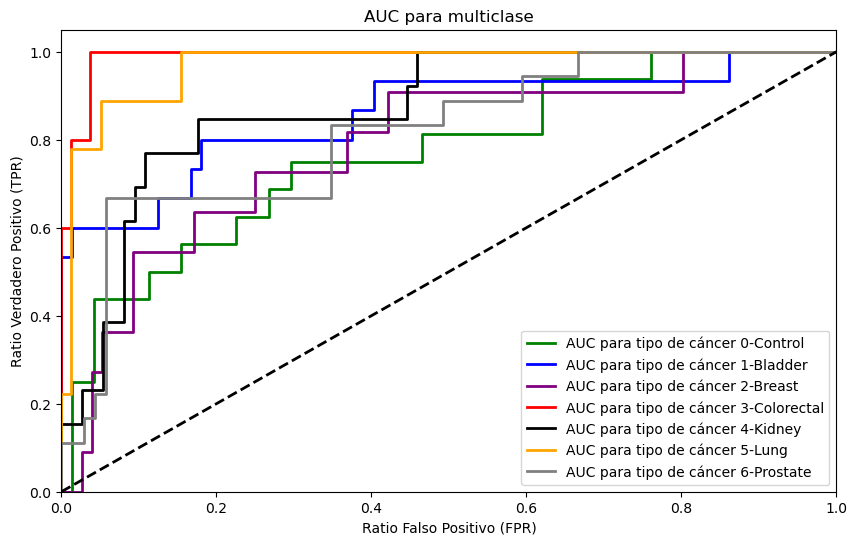

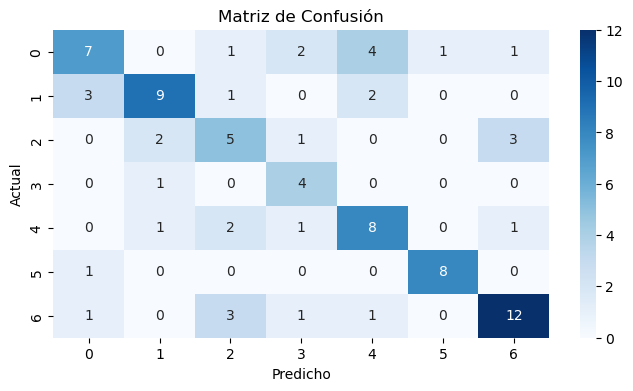



Puntuación Jaccard para el cáncer tipo 0-Control.... 0.3333
Puntuación Jaccard para el cáncer tipo 1-Bladder.... 0.4737
Puntuación Jaccard para el cáncer tipo 2-Breast..... 0.2778
Puntuación Jaccard para el cáncer tipo 3-Colorectal. 0.4000
Puntuación Jaccard para el cáncer tipo 4-Kidney..... 0.4000
Puntuación Jaccard para el cáncer tipo 5-Lung....... 0.8000
Puntuación Jaccard para el cáncer tipo 6-Prostate... 0.5217

Media de la puntuación de Jaccard: 0.4581


In [10]:
if M_TIPO.startswith("bin"):
    myfunc.ver_metricas(mejor_modelo, X_test, y_test)
else:
    myfunc.ver_metricas_multi(mejor_modelo, X_test, y_test)


#### Finalización del notebook

In [11]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
myfunc.verbose(f"Notebook ha tardado {total_time.seconds} seconds")

20231029T223107 : enderlab : INFO : Notebook ha tardado 1627 seconds


#### Guardar métricas

In [12]:
if M_TIPO.startswith("bin"):
    myfunc.save_metricas_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)
else:
    myfunc.save_metricas_multi_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)

df1=myfunc.read_metricas_to_df(myfunc.MET_DIR,M_FICHERO)

display(df1.sort_values("datetime", ascending=False)[:3])


20231029T223107 : enderlab : INFO : Inicio guardar métricas multiclase
20231029T223107 : enderlab : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv
20231029T223107 : enderlab : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv


20231029T223107 : enderlab : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv
20231029T223107 : enderlab : INFO : Fichero borrado ../tfm_git/ejecuciones/metricas/metricas_8270.csv
20231029T223107 : enderlab : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv
20231029T223107 : enderlab : INFO : Fin guardar métricas multiclase
20231029T223107 : enderlab : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv


20231029T223107 : enderlab : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_8270.csv


,tipo,select,clasific,semilla,accuracy,precision,recall,f1_score,roc_auc,hostname,total_time_sec,datetime,fichero_modelo,params,shape,features,roc_auc_ovr,indices_auc,indices_jaccard
0,mul_m,ANOVA,LR_L1,8270,0.609195,0.609265,0.637569,0.613586,NaN,enderlab,1627,2023-10-29 22:31:07.234858,modelo_8270_mul_m_ANOVA_LR_L1.pkl,"{'selector__k': 1000, 'clasifier__solver': 'sa...","X_test:(87, 18875)","['ENSG00000000938.13', 'ENSG00000002919.15', '...",0.865713,"[0.7684859154929577, 0.8583333333333334, 0.785...","[0.3333333333333333, 0.47368421052631576, 0.27..."
0,mul_m,ANOVA,LR_EN,8270,0.620690,0.627038,0.648558,0.622170,NaN,enderlab,1813,2023-10-29 22:03:53.255729,modelo_8270_mul_m_ANOVA_LR_EN.pkl,"{'selector__k': 1000, 'clasifier__solver': 'sa...","X_test:(87, 18875)","['ENSG00000000938.13', 'ENSG00000002919.15', '...",0.870458,"[0.7579225352112676, 0.8740740740740741, 0.791...","[0.35, 0.5294117647058824, 0.2777777777777778,..."
0,bin_s,RF,SVM,8270,0.617978,0.618503,0.615268,0.614031,0.67998,enderlab,10,2023-10-29 21:33:33.005715,modelo_8270_bin_s_RF_SVM.pkl,"{'selector__max_features': 500, 'selector__est...","X_test:(89, 18875)","['ENSG00000000938.13', 'ENSG00000002587.10', '...",NaN,NaN,NaN


#### Guardar resultados

In [13]:
fichero_resultados=R_FICHERO+"_"+M_TIPO+"-"+M_SELECT+"-"+M_CLASIF+".csv"
myfunc.save_resultados_to_csv(M_TIPO, M_SELECT, M_CLASIF,  random_search, myfunc.MET_DIR, fichero_resultados)


20231029T223107 : enderlab : INFO : Inicio guardar resultados
20231029T223107 : enderlab : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/resultados_8270_mul_m-ANOVA-LR_L1.csv
20231029T223107 : enderlab : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/resultados_8270_mul_m-ANOVA-LR_L1.csv
20231029T223107 : enderlab : INFO : Fin guardar resultados
